<a href="https://colab.research.google.com/github/steven1174/Applied-Econometric-Time-Series-WE/blob/master/Inventory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authentication

In [266]:
from google.colab import auth
from google.auth import default

auth.authenticate_user()
creds, _ = default()

# Libraries

In [267]:
%%capture
!pip install gspread

In [268]:
import numpy as np
import pandas as pd

import requests
import io

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

In [270]:
import pprint
import missingno

# Funtions

In [271]:
def export_sheets(dataframe,url,worksheet_name,row = 1, col = 1):
    gc = gspread.authorize(creds)
    sheet = gc.open_by_url(url)
    worksheet = sheet.worksheet(worksheet_name)

    set_with_dataframe(worksheet,dataframe,row = row, col = col)

In [272]:
def import_sheets(url,worksheet_name):
    gc = gspread.authorize(creds)
    sheet = gc.open_by_url(url)
    worksheet = sheet.worksheet(worksheet_name)
    rows = worksheet.get_all_values()
    df = pd.DataFrame.from_records(rows)
    df.columns = df.iloc[0]
    df.drop([0],axis=0,inplace=True)

    return df

In [273]:
def settings():
    url = "https://parcela-agfin.waalo.co/web/export/csv"

    files=[]

    headers = {
        'Accept': '*/*',
        'Accept-Language': 'es-ES,es;q=0.9',
        'Connection': 'keep-alive',
        'Cookie': 'session_id=f67754647d10ec7544d365e1bb70d025a292fd90; fileToken=dummy-because-api-expects-one; session_id=f67754647d10ec7544d365e1bb70d025a292fd90',
        'Origin': 'https://parcela-agfin.waalo.co',
        'Referer': 'https://parcela-agfin.waalo.co/web',
        'Sec-Fetch-Dest': 'empty',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Site': 'same-origin',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
        'sec-ch-ua': '"Not_A Brand";v="99", "Google Chrome";v="109", "Chromium";v="109"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"'
    }

    return url, files, headers

# Dataframe DB

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1Wu1Cl6owQsTWdpHl-ey4Bxrt-i9Ulfu9Z1A0_1EJ00Y/edit#gid=1684855672'

df_products = import_sheets(url,'products')

# Dataframe Receptions


In [155]:
input = \
{'data': '{"model":"stock.picking","fields":['
               '{"name":"name","label":"Referencia"},'
               '{"name":"location_id","label":"Ubicación de origen"},'
               '{"name":"location_dest_id","label":"Ubicación destino"},'
               '{"name":"origin","label":"Documento origen"},'
               '{"name":"date","label":"Fecha de Creación"},'
               '{"name":"date_done","label":"Fecha de transferencia"},'
               '{"name":"state","label":"Estado"},'
               '{"name":"move_lines","label":"Movimientos de stock"},'
               '{"name":"move_lines/product_id/categ_id","label":"Movimientos de stock/Producto/Categoría de producto"},'
               '{"name":"move_lines/purchase_line_id","label":"Movimientos de stock/Línea de pedido de compra"},'
               '{"name":"move_lines/purchase_line_id/product_qty","label":"Movimientos de stock/Línea de pedido de compra/Cantidad"},'
               '{"name":"move_lines/purchase_line_id/qty_received","label":"Movimientos de stock/Línea de pedido de compra/Ctdad recibida"},'
               '{"name":"move_lines/purchase_line_id/product_uom","label":"Movimientos de stock/Línea de pedido de compra/Unidad de medida"}'
         '],"ids":false,"domain":[["picking_type_id","=",1],["date",">","2022-12-31 23:59:59"]],"groupby":[],'
         '"context":{"lang":"es_ES","tz":"America/Bogota","uid":7,"allowed_company_ids":[1],"active_model":"stock.picking.type","active_id":1,"active_ids":[1],"contact_display":"partner_address","search_default_picking_type_id":[1],"default_picking_type_id":1,"default_immediate_transfer":true,"default_company_id":1},"import_compat":false}',
 'token': 'dummy-because-api-expects-one',
 'csrf_token': 'eb3bedb7f0951052e53ab78c97fdf101a5af163fo1706296195'}

In [156]:
url, files, headers = settings()

In [157]:
response = requests.request("GET", url, headers=headers, data=input, files=files)

In [158]:
with io.BytesIO(response.content) as fh:
    df1 = pd.read_csv(fh)

In [167]:
df1.columns = ['reference','location_id','location_dest_id','origin','creation_date','transfer_date','status','move_lines','categ_id','products','product_qty','qty_received','product_uom']

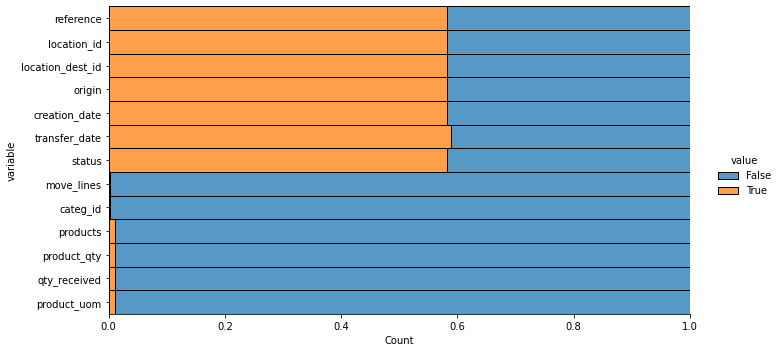

In [168]:
df1.isna().melt().pipe(
    lambda df:
      sns.displot( data = df,
                    y = 'variable',
                    hue = 'value',
                    multiple = 'fill',
                    aspect = 2
                ) 
)

plt.show()

In [191]:
df1_ = df1.copy()

In [192]:
headers = ['reference','location_id','location_dest_id','origin','creation_date','transfer_date','status']

for name in headers: 
    df1_["{0}".format(name)].fillna(method = 'ffill', inplace = True)

In [193]:
df1_['categ_id'] = df1_.categ_id.str.split('/').str[1].str.strip().str.upper()
df1_['product_code'] = df1_.products.str.split('[').str[1].str.split(']').str[0].str.strip()

In [194]:
df1_['creation_date'] = pd.to_datetime(df1_['creation_date'])
df1_['transfer_date'] = pd.to_datetime(df1_['transfer_date'])

In [195]:
df1_ = df1_[['reference','location_id','location_dest_id','origin','creation_date','transfer_date','status','move_lines','categ_id','product_code','products','product_qty','qty_received','product_uom']]

In [206]:
condition1 = df1_.status == 'Hecho'
condition2 = ~ (df1_.products.str.upper() == 'OTR')
condition3 = ~ df1_.categ_id.isin(['ACTIVOS FIJOS','PRUEBA']) # & (df_.categ_id.notna())
condition4 = True

conditions = condition1 & condition2 & condition3 & condition4

df1_ = df1_.loc[conditions]

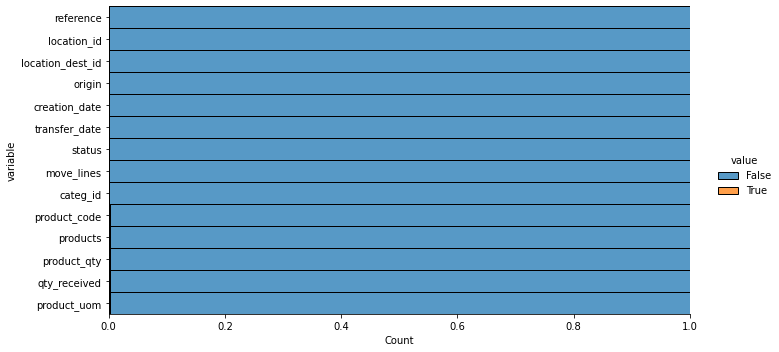

In [207]:
df1_.isna().melt().pipe(
    lambda df:
      sns.displot( data = df,
                    y = 'variable',
                    hue = 'value',
                    multiple = 'fill',
                    aspect = 2
                ) 
)

plt.show()

In [288]:
# df1_.to_excel('df1.xlsx', index = False)

# Dataframe Expeditions

In [290]:
input = \
{'data': '{"model":"stock.picking","fields":['
               '{"name":"name","label":"Referencia"},'
               '{"name":"location_id","label":"Ubicación de origen"},'
               '{"name":"location_dest_id","label":"Ubicación destino"},'
               '{"name":"origin","label":"Documento origen"},'
               '{"name":"date","label":"Fecha de Creación"},'
               '{"name":"date_done","label":"Fecha de transferencia"},'
               '{"name":"state","label":"Estado"},'
               '{"name":"move_lines","label":"Movimientos de stock"},'
               '{"name":"move_lines/product_id/categ_id","label":"Movimientos de stock/Producto/Categoría de producto"},'
               '{"name":"move_lines/sale_line_id","label":"Movimientos de stock/Línea de venta"},'
               '{"name":"move_lines/sale_line_id/product_qty","label":"Movimientos de stock/Línea de pedido de compra/Cantidad"},'
               '{"name":"move_lines/sale_line_id/qty_delivered","label":"Movimientos de stock/Línea de venta/Cantidad Entregada"},'
               '{"name":"move_lines/sale_line_id/product_uom","label":"Movimientos de stock/Línea de venta/Unidad de medida"}'
         '],"ids":false,"domain":[["picking_type_id","=",2],["date",">","2022-12-31 23:59:59"]],"groupby":[],'
         '"context":{"lang":"es_ES","tz":"America/Bogota","uid":7,"allowed_company_ids":[1],"active_model":"stock.picking.type","active_id":1,"active_ids":[1],"contact_display":"partner_address","search_default_picking_type_id":[1],"default_picking_type_id":1,"default_immediate_transfer":true,"default_company_id":1},"import_compat":false}',
 'token': 'dummy-because-api-expects-one',
 'csrf_token': 'eb3bedb7f0951052e53ab78c97fdf101a5af163fo1706296195'}


In [291]:
url, files, headers = settings()

In [292]:
response = requests.request("GET", url, headers=headers, data=input, files=files)

In [293]:
with io.BytesIO(response.content) as fh:
    df2 = pd.read_csv(fh)

In [294]:
df2.columns = ['reference','location_id','location_dest_id','origin','creation_date','transfer_date','status','move_lines','categ_id','products','product_qty','qty_delivered','product_uom']

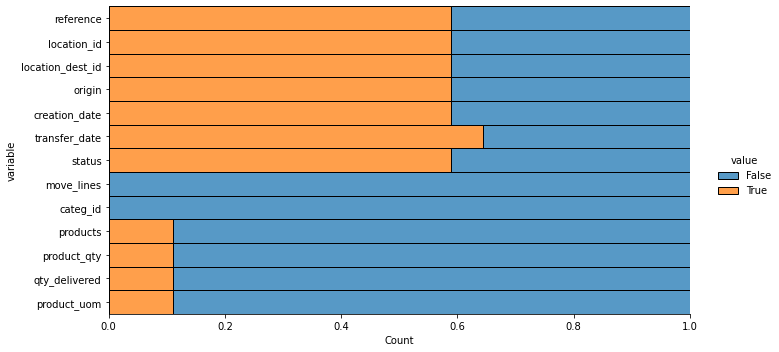

In [295]:
df2.isna().melt().pipe(
    lambda df:
      sns.displot( data = df,
                    y = 'variable',
                    hue = 'value',
                    multiple = 'fill',
                    aspect = 2
                ) 
)

plt.show()

In [296]:
df2_ = df2.copy()

In [297]:
headers = ['reference','location_id','location_dest_id','origin','creation_date','transfer_date','status']

for name in headers: 
    df2_["{0}".format(name)].fillna(method = 'ffill', inplace = True)

In [298]:
df2_['categ_id'] = df2_.categ_id.str.split('/').str[1].str.strip().str.upper()
df2_['product_code'] = df2_.products.str.split('[').str[1].str.split(']').str[0].str.strip()

In [299]:
df2_['creation_date'] = pd.to_datetime(df2_['creation_date'])
df2_['transfer_date'] = pd.to_datetime(df2_['transfer_date'])

In [300]:
df2_ = df2_[['reference','location_id','location_dest_id','origin','creation_date','transfer_date','status','move_lines','categ_id','product_code','products','product_qty','qty_delivered', 'product_uom']]

In [301]:
df2_.status.value_counts()

Hecho        3933
Cancelado     599
Preparado      30
Borrador        1
Name: status, dtype: int64

In [ ]:
condition1 = df1_.status == 'Hecho'
condition2 = ~ (df1_.products.str.upper() == 'OTR')
condition3 = ~ df1_.categ_id.isin(['ACTIVOS FIJOS','PRUEBA']) # & (df_.categ_id.notna())
condition4 = True

conditions = condition1 & condition2 & condition3 & condition4

df1_ = df1_.loc[conditions]

In [303]:
condition1 = df2_.status == 'Hecho'
condition2 = True #~ (df1_.products.str.upper() == 'OTR')
condition3 = True #~ df1_.categ_id.isin(['ACTIVOS FIJOS','PRUEBA']) # & (df_.categ_id.notna())
condition4 = True #

conditions = condition1 & condition2 & condition3 & condition4

df2_ = df2_.loc[conditions]

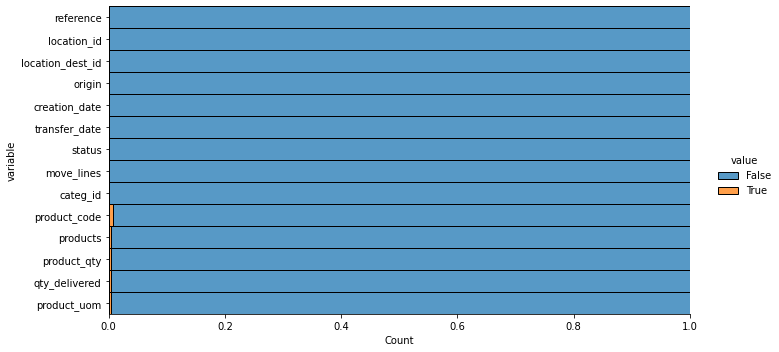

In [304]:
df2_.isna().melt().pipe(
    lambda df:
      sns.displot( data = df,
                    y = 'variable',
                    hue = 'value',
                    multiple = 'fill',
                    aspect = 2
                ) 
)

plt.show()

In [308]:
df2_.loc[(df2_.origin == 'OV-06598')]

,reference,location_id,location_dest_id,origin,creation_date,transfer_date,status,move_lines,categ_id,product_code,products,product_qty,qty_delivered,product_uom
26,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/MVG01: WH>Clientes,MANGO TOMMY,MVG01,OV-06598 - [MVG01] MANGO VERDE GRUESO / KG,40.0,36.0,kg
27,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/MVP01: WH>Clientes,MANGO TOMMY,MVP01,OV-06598 - [MVP01] MANGO VERDE PAREJO / KG,40.0,0.0,kg
28,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/MPG01: WH>Clientes,MANGO TOMMY,MPG01,OV-06598 - [MPG01] MANGO PINTON GRUESO / KG,20.0,0.0,kg
29,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/MPP01: WH>Clientes,MANGO TOMMY,MPP01,OV-06598 - [MPP01] MANGO PINTON PAREJO / KG,20.0,20.0,kg
30,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/GPPP01: WH>Clientes,GUAYABA,GPPP01,OV-06598 - [GPPP01] GUAYABA PERA PINTON PAREJO...,15.0,0.0,kg
31,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/GPPG01: WH>Clientes,GUAYABA,GPPG01,OV-06598 - [GPPG01] GUAYABA PERA PINTON GRUESA...,15.0,15.0,kg
32,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/PTG01: WH>Clientes,PAPAYA,PTG01,OV-06598 - [PTG01] PAPAYA TAINUNG GRUESA / KG,18.0,13.0,kg
33,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/GPPG01: WH>Clientes,GUAYABA,GPPG01,OV-06598 - [GPPG01] GUAYABA PERA PINTON GRUESA...,18.0,0.0,kg
34,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/LTE01: WH>Clientes,LIMON TAHITI,LTE01,OV-06598 - [LTE01] LIMON TAHITI ESTANDAR / KG,20.0,20.0,kg
35,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/MMP01: WH>Clientes,MANGO TOMMY,NaN,NaN,NaN,NaN,NaN


In [307]:
df2_.loc[df2_.product_code.isna() & (df2_.origin == 'OV-06598')] #.to_excel('df2.xlsx', index = False)

,reference,location_id,location_dest_id,origin,creation_date,transfer_date,status,move_lines,categ_id,product_code,products,product_qty,qty_delivered,product_uom
35,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/MMP01: WH>Clientes,MANGO TOMMY,NaN,NaN,NaN,NaN,NaN
36,WH/SA/07376,WH,Partner Locations/Clientes,OV-06598,2023-01-02 18:26:03,2023-01-03 08:05:57,Hecho,OV-06598/MMG01: WH>Clientes,MANGO TOMMY,NaN,NaN,NaN,NaN,NaN


# Discussion

In [ ]:
# df_.loc[df_.move_lines.isna()].status.value_counts()
# df_.loc[df_.origin == 'OC-01309']
df.loc[df_.status == 'Borrador']

,reference,location_id,location_dest_id,schedule_date,origin,status,product_qty,move_lines,purchase_line_id,qty_received,product_uom,categ_id
809,WH/EN/00310,Partner Locations/Vendors,WH/Stock,2022-09-13 18:20:34,OC-00163,Borrador,NaN,NaN,NaN,NaN,NaN,NaN
919,WH/EN/00347,Partner Locations/Vendors,WH/Stock,2022-09-20 17:15:48,OC-00182,Borrador,NaN,NaN,NaN,NaN,NaN,NaN
1095,WH/EN/00430,Partner Locations/Vendors,WH/Stock,2022-09-28 18:38:48,OC-00250,Borrador,NaN,NaN,NaN,NaN,NaN,NaN
1198,WH/EN/00467,Partner Locations/Vendors,WH/Stock,2022-10-03 11:52:55,OC-00254,Borrador,NaN,NaN,NaN,NaN,NaN,NaN
2148,WH/EN/00908,Partner Locations/Vendors,WH/Stock,2022-11-08 09:09:17,OC-00490,Borrador,NaN,NaN,NaN,NaN,NaN,NaN
2149,WH/EN/00907,Partner Locations/Vendors,WH/Stock,2022-11-08 09:09:17,OC-00490,Borrador,NaN,NaN,NaN,NaN,NaN,NaN
2150,WH/EN/00910,Partner Locations/Vendors,WH/Stock,2022-11-08 09:09:18,OC-00490,Borrador,NaN,NaN,NaN,NaN,NaN,NaN
2151,WH/EN/00909,Partner Locations/Vendors,WH/Stock,2022-11-08 09:09:18,OC-00490,Borrador,NaN,NaN,NaN,NaN,NaN,NaN
2235,WH/EN/00955,Partner Locations/Vendors,WH/Stock,2022-11-09 14:41:02,OC-00647,Borrador,NaN,NaN,NaN,NaN,NaN,NaN
2236,WH/EN/00954,Partner Locations/Vendors,WH/Stock,2022-11-09 14:41:02,OC-00647,Borrador,NaN,NaN,NaN,NaN,NaN,NaN


# Export


In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1Wu1Cl6owQsTWdpHl-ey4Bxrt-i9Ulfu9Z1A0_1EJ00Y/edit#gid=0'
worksheet = 'inventory'

export_sheets(df,url,worksheet)